# Image Classification using Machine Learning and Deep Learning Algorithms

# The aim of the project

The goal of this project is to apply **machine learning** algorithms and a **neural network** model to accurately predict the type of clothing represented in the images from the Fashion-MNIST dataset.

This approach will enable the evaluation of the performance of different methods in **classifying images** of clothing items.

# About the data

The data used is sourced from the **Fashion-MNIST** dataset, available on Kaggle. Each row represents a 28x28 pixel image, where the first column indicates the class of the clothing item, and the remaining values (0-255) reflect the pixel intensity. The dataset includes 60,000 examples for training and 10,000 for testing.

**Libraries**

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools
import sys


from matplotlib import rcParams
from sklearn import metrics
from sklearn import tree
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, jaccard_score, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import recall_score,f1_score
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fashion-mnist/fashion/fashion-mnist_test.csv
/kaggle/input/fashion-mnist/fashion/fashion-mnist_train.csv


In [2]:
# Reading the files
train_data = pd.read_csv("/kaggle/input/fashion-mnist/fashion/fashion-mnist_train.csv")
test_data = pd.read_csv("/kaggle/input/fashion-mnist/fashion/fashion-mnist_test.csv")

In [3]:
# Printing the data from the files
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Training data
print("\n" + "="*80)  
print("  Training data  ".center(80, "="))  
print("="*80) 
print(train_data.iloc[:10, :10])

print("\n" + "="*80) 

# Testing data
print("  Testing data  ".center(80, "="))  
print("="*80) 
print(test_data.iloc[:10, :10])


===============================  Training data  ================================
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9
0      2       0       0       0       0       0       0       0       0       0
1      9       0       0       0       0       0       0       0       0       0
2      6       0       0       0       0       0       0       0       5       0
3      0       0       0       0       1       2       0       0       0       0
4      3       0       0       0       0       0       0       0       0       0
5      4       0       0       0       5       4       5       5       3       5
6      4       0       0       0       0       0       0       0       0       0
7      5       0       0       0       0       0       0       0       0       0
8      4       0       0       0       0       0       0       3       2       0
9      8       0       0       0       0       0       0       0       0       0

==========================

# Understanding and preparing the data

At this stage, I evaluate the data quality by searching for missing values in the training and testing sets. Then, I separate the features (pixel data) from the target variable (label, representing the clothing item class). Finally, I normalize the data to ensure consistent scaling, enhancing the performance of machine learning models.

**Data Quality**

In [4]:
# Verifiyng datasets structure
print(f"Training dataset structure: {train_data.shape}")
print(f"Testing dataset structure: {test_data.shape}")

Training dataset structure: (60000, 785)
Testing dataset structure: (10000, 785)


I observe that there are 60,000 observations in the training set and 10,000 in the testing set.

Additionally, there are 785 features in both datasets, where one feature represents the clothing item class, and the remaining 784 are pixel features (28*28 = 784 pixels).

In [5]:
# Check for missing values in train_data
print("Missing values in the training set:")
print(train_data.isna().sum().sum())

# Check for missing values in test_data
print("Missing values in the testing set:")
print(test_data.isna().sum().sum())

Missing values in the training set:
0
Missing values in the testing set:
0


Since there are no missing values in the datasets, I don’t need to apply techniques for handling missing values (imputation or removal). Therefore, I can continue working with the data without cleaning it.

**Understanding the data**

In [6]:
pd.set_option('display.max_rows', 10)  
pd.set_option('display.max_columns', 5) 
pd.set_option('display.width', 1000) 

# Data types of each column
print("\nData types of each column:")
print(train_data.dtypes)

print("\n")

# Statistical summary of the data
print("Statistical summary of the data:")
print(train_data.describe().head(10))


Data types of each column:
label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object


Statistical summary of the data:
              label        pixel1  ...      pixel783     pixel784
count  60000.000000  60000.000000  ...  60000.000000  60000.00000
mean       4.500000      0.000900  ...      0.855517      0.07025
std        2.872305      0.094689  ...      9.356960      2.12587
min        0.000000      0.000000  ...      0.000000      0.00000
25%        2.000000      0.000000  ...      0.000000      0.00000
50%        4.500000      0.000000  ...      0.000000      0.00000
75%        7.000000      0.000000  ...      0.000000      0.00000
max        9.000000     16.000000  ...    255.000000    170.00000

[8 rows x 785 columns]


I observe that all data is numeric (int64 - integers).

The data description shows that the labels are located in the first column of the table, with values ranging from 0 to 9, representing the clothing item classes.

Pixel values range from 0 to 255, where 0 represents black (dark) and 255 represents white (bright), with intermediate values indicating shades of gray. Most pixels appear to have low values, suggesting a predominantly dark or grayscale image.

**Data preparation**

In [7]:
# Separating features from the target variable (label)
X_train = train_data.iloc[:, 1:].values  
y_train = train_data.iloc[:, 0].values   

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

I have separated the features (pixels) from the target variable (clothing item class) in the training and testing datasets.

In X_train and X_test, the pixel values are stored, while in y_train and y_test, the corresponding labels (target variable) are stored. This process prepares the data for training a machine learning model.

In [8]:
# Normalizing values
scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

I have normalized the pixel values using the MinMaxScaler function to scale the values within a uniform range.

This transformation ensures that the pixel values are between 0 (white) and 1 (black), making the data easier to process for machine learning models.

**Data Visualization**

I have displayed 10 images from the training set to illustrate how clothing items are represented through the pixels in the datasets. Each image has the original size of 28x28 pixels, providing a clear visualization of the clothing items.

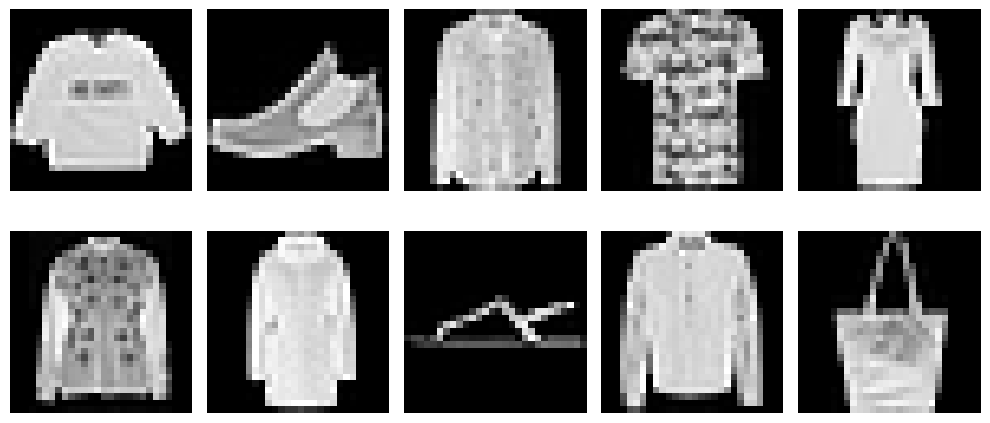

In [9]:
# Visualizing the clothing items' images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_norm[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Target variable analysis

At this stage, I have analyzed the distribution of classes in the dataset to check if there is an equilibrium between the categories, which is crucial for the performance of classification algorithms.

In [10]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

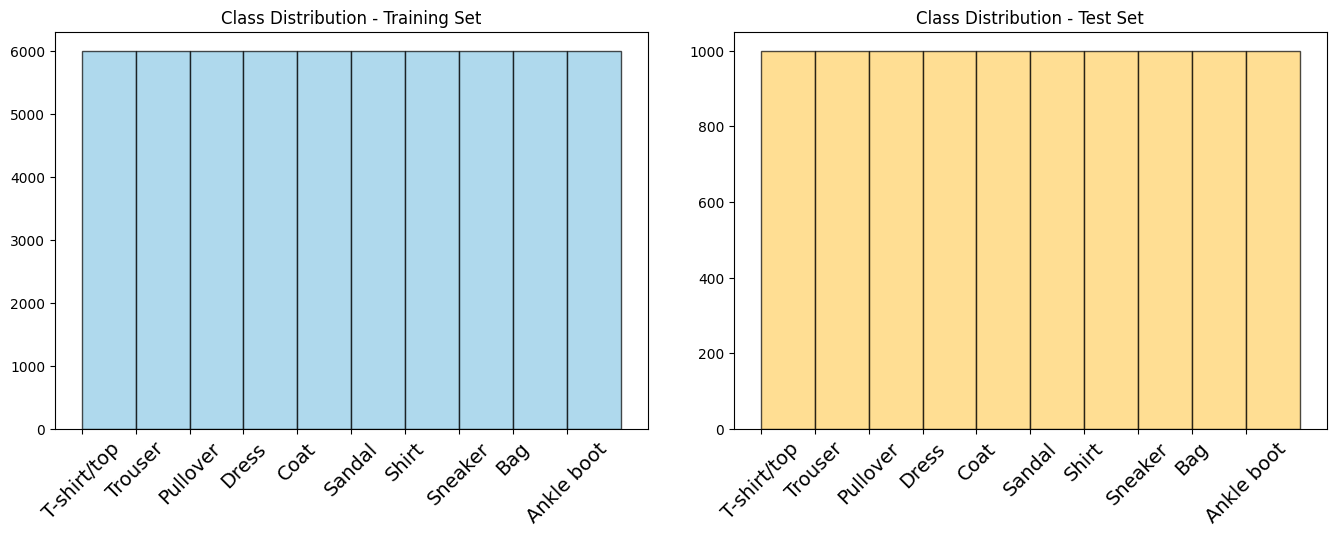

In [11]:
# Histograms
plt.figure(figsize=(14, 6))

# Training
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=range(11), edgecolor='black', alpha=0.7, color='#8ecae6', align='mid')
plt.title("Class Distribution - Training Set")
plt.xticks(range(10), classes, fontsize=14, rotation=45)

# Testing
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=range(11), edgecolor='black', alpha=0.7, color='#ffd166', align='mid')
plt.title("Class Distribution - Test Set")
plt.xticks(range(10), classes, fontsize=14, rotation=45)

plt.tight_layout(pad=3)
plt.show()


By analyzing the histograms, we can conclude that the distribution of observations across classes is balanced in both the training and testing sets, with each class having an identical number of observations. This ensures favorable conditions for the correct training and evaluation of classification algorithms.

# Machine Learning Algorithms

**KNN**

KNN is a supervised machine learning algorithm used for classification and regression. It works by comparing a new example with existing data and classifying it based on the closest k neighbors, using a distance measure, such as Euclidean distance.

Fashion-MNIST contains clothing images represented numerically through pixel intensity values (0-255). KNN is useful here because it can directly compare these values to determine the classes of clothing items.

In [12]:
k_values = [i for i in range (1,10)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, leaf_size=100, p=2, metric='minkowski')
    score = cross_val_score(knn, X_train_norm, y_train, cv=3)
    scores.append(np.mean(score))

By using cross-validation, I have determined the optimal value for the KNN model. This process helps identify the best value for the hyperparameter k, which defines the number of neighbors to consider when making predictions, ultimately improving the model's performance.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Accuracy Score')

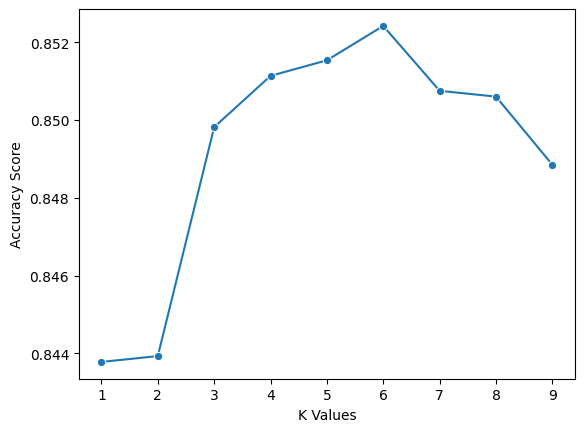

In [13]:
# Graphic representation of results
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [14]:
# Finding the best k value
best_index = np.argmax(scores)
best_k = k_values[best_index]
best_k

6

Building the KNN model using the optimal k value.

In [15]:
k = 6

KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train_norm, y_train.ravel())
KNN

KNeighborsClassifier(n_neighbors=6)

Prediction on the test set.

In [16]:
# Prediction
y_pred_knn = KNN.predict(X_test_norm)
y_pred_knn[0:5]

array([0, 1, 2, 2, 3])

Testing the accuracy of the predictions.

In [17]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, KNN.predict(X_train_norm)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred_knn))

Train set Accuracy:  0.8931166666666667
Test set Accuracy:  0.8607


The accuracy of the model on the test set is 0.8607, indicating that the model correctly predicted approximately 86.07% of the test labels. This is a fairly good accuracy, showing that the model successfully predicted correctly in most cases.

Function to create a confusion matrix.

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

Creating confusion matrix for KNN.

In [19]:
# Creating confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_knn)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.75      0.82      0.78      1000
           3       0.92      0.88      0.90      1000
           4       0.81      0.79      0.80      1000
           5       0.99      0.83      0.90      1000
           6       0.69      0.57      0.63      1000
           7       0.88      0.95      0.91      1000
           8       0.98      0.95      0.96      1000
           9       0.89      0.96      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



An average F1 score of 0.86 suggests a balanced model with good performance in identifying most classes. The recall reflects how well the model identifies positive instances (TP/TP+FN), and in this case, there is room for improvement in some classes, such as class 6. Overall, the accuracy and F1-score are good, but recall could be optimized.

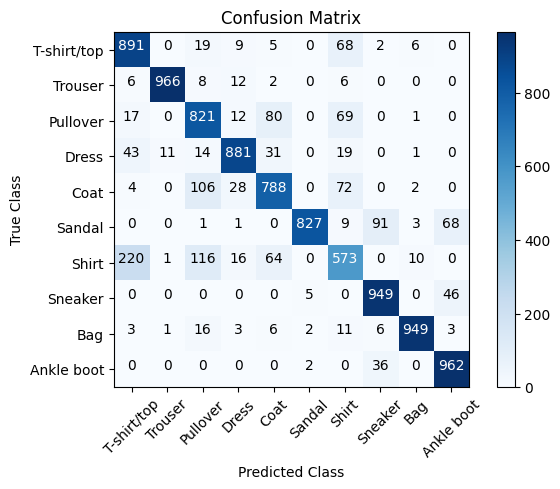

In [20]:
# Confusion Matrix representation

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                      normalize=False, title='Confusion Matrix')

From the confusion matrix, it can be observed that the algorithm predicts the classes "Trouser" and "Ankle boot" very well, with 966 and 962 correct predictions, respectively. A class with a high number of errors (almost half of the total) is "Shirt," which is most often confused with "T-shirt/top." Additionally, images of "Coat" were frequently confused with "Pullover." The remaining categories show good results, with more than 800 correct predictions for each.

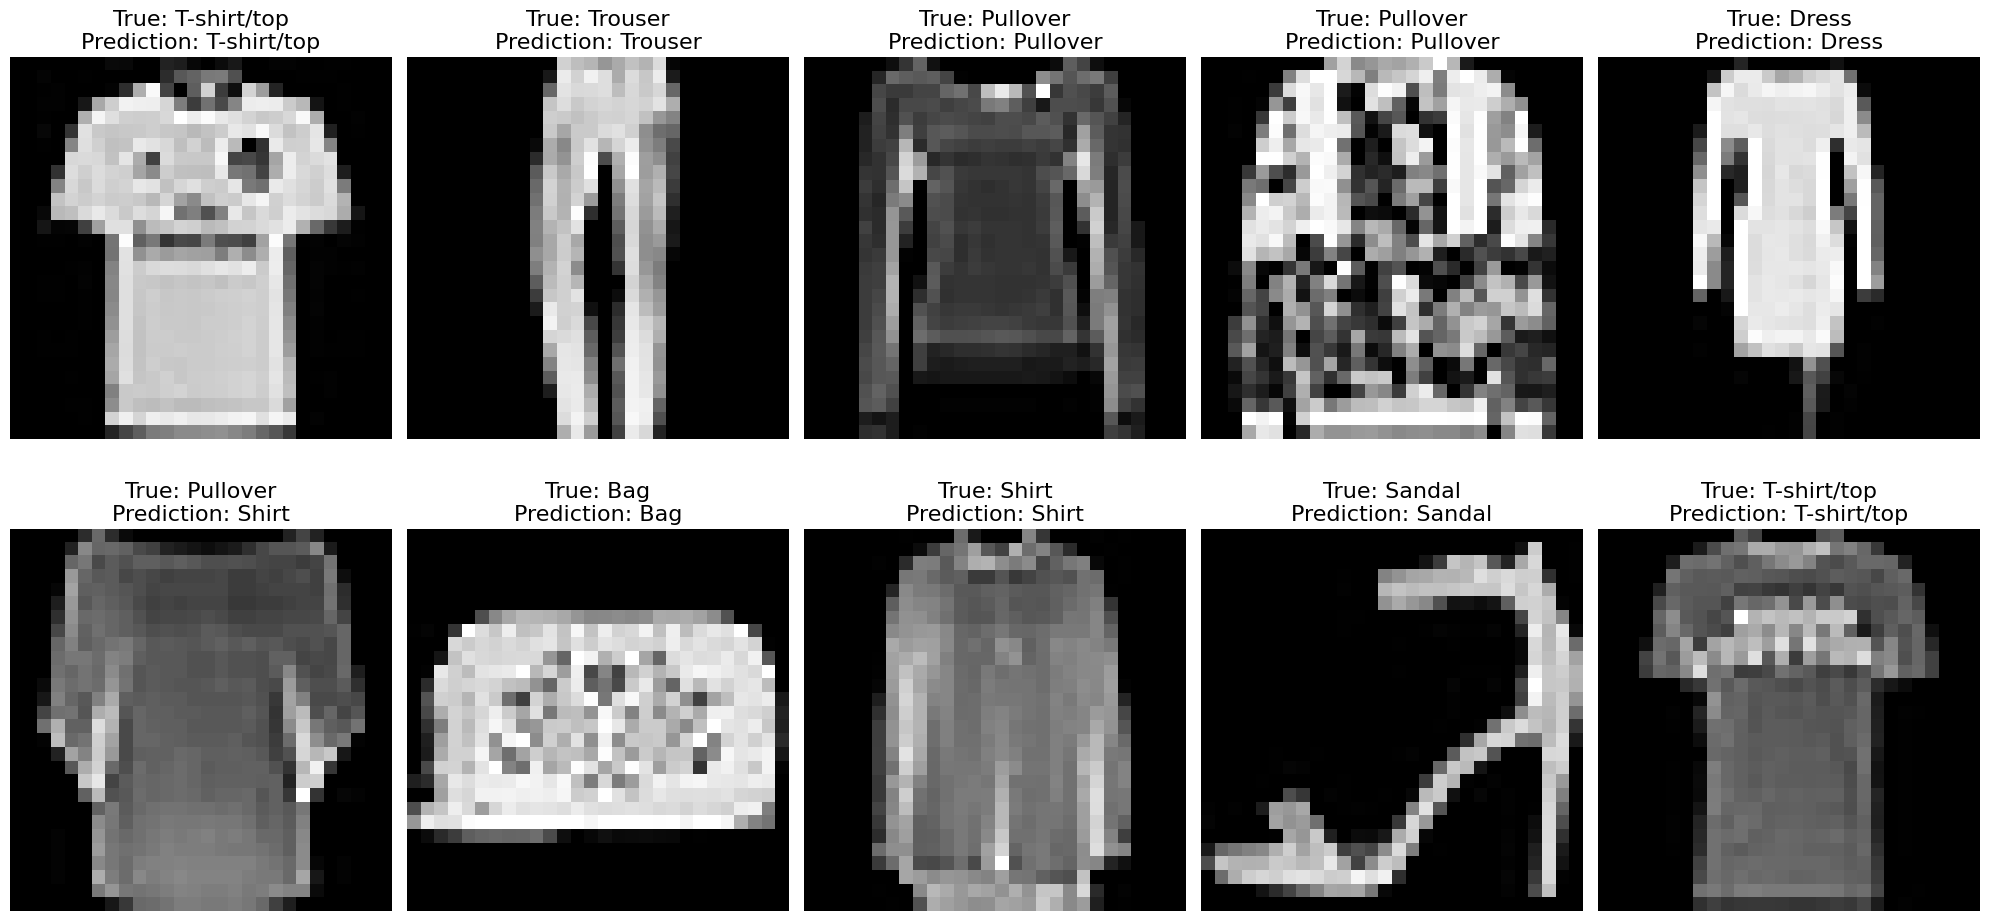

In [21]:
num_images = 10
images = X_test[:num_images]
true_labels = y_test[:num_images]
predicted_labels = KNN.predict(X_test_norm[:num_images])

image_size = int(np.sqrt(images.shape[1]))
reshaped_images = images.reshape(-1, image_size, image_size)

plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(reshaped_images[i], cmap='gray')
    true_label = classes[true_labels[i]]
    predicted_label = classes[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPrediction: {predicted_label}", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

I tested the model on a set of 10 images to evaluate its classification performance. The KNN algorithm made a single mistake, misclassifying a "Pullover" as a "Shirt." However, it correctly identified all the other objects, indicating a solid ability to distinguish and classify objects in the images.

**Classification and Decision Trees**

A decision tree is a machine learning algorithm of the white-box type. It shares the internal decision-making logic, which is not available in black-box algorithms, such as neural networks. Its training time is faster compared to neural network algorithms. Decision trees are used to predict the membership of objects in distinct categories based on their values/measures in relation to one or more predictor variables. It is a flexible and attractive method that allows for the creation of insightful graphical representations.

In [22]:
# Creating and training the classification tree - ENTROPY
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=40)
clf_entropy = clf_entropy.fit(X_train, y_train)

In [23]:
# Making the prediction
y_pred_entropy = clf_entropy.predict(X_test)
y_pred_entropy

# Get the probabilities for each class
y_pred_entropy_proba = clf_entropy.predict_proba(X_test)
y_pred_entropy_proba

array([[6.08e-01, 0.00e+00, 9.23e-03, ..., 0.00e+00, 5.64e-03, 0.00e+00],
       [4.17e-04, 9.96e-01, 0.00e+00, ..., 0.00e+00, 6.25e-04, 0.00e+00],
       [2.53e-02, 1.87e-02, 6.79e-01, ..., 0.00e+00, 3.25e-02, 7.79e-04],
       ...,
       [7.42e-03, 0.00e+00, 4.45e-03, ..., 9.35e-02, 7.54e-01, 2.97e-03],
       [3.29e-02, 2.35e-03, 1.88e-02, ..., 0.00e+00, 7.36e-01, 5.65e-02],
       [2.53e-02, 1.87e-02, 6.79e-01, ..., 0.00e+00, 3.25e-02, 7.79e-04]])

In [24]:
# Model Evaluation
print("Accuracy_ENTROPY:", metrics.accuracy_score(y_test, y_pred_entropy))
auc_entropy = roc_auc_score(y_test, y_pred_entropy_proba, multi_class='ovr')
print("AUC_ENTROPY:", auc_entropy)
precision_entropy = precision_score(y_test, y_pred_entropy, average='weighted')
print("Precision_ENTROPY:", precision_entropy)

Accuracy_ENTROPY: 0.7087
AUC_ENTROPY: 0.9491339999999999
Precision_ENTROPY: 0.7062958682436807


In [25]:
# Creating and training the classification tree - GINI
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=40)
clf_gini = clf_gini.fit(X_train, y_train)

In [26]:
# Making the prediction
y_pred_gini = clf_gini.predict(X_test)
y_pred_gini

# Get the probabilities for each class
y_pred_gini_proba = clf_gini.predict_proba(X_test)
y_pred_gini_proba

array([[8.28e-01, 2.19e-04, 1.65e-02, ..., 0.00e+00, 2.63e-03, 0.00e+00],
       [1.41e-03, 9.91e-01, 1.01e-03, ..., 0.00e+00, 8.08e-04, 0.00e+00],
       [6.90e-02, 4.32e-03, 5.77e-01, ..., 0.00e+00, 4.20e-02, 3.68e-03],
       ...,
       [1.20e-02, 1.15e-03, 1.81e-02, ..., 1.72e-03, 8.80e-01, 3.72e-03],
       [6.90e-02, 4.32e-03, 5.77e-01, ..., 0.00e+00, 4.20e-02, 3.68e-03],
       [6.90e-02, 4.32e-03, 5.77e-01, ..., 0.00e+00, 4.20e-02, 3.68e-03]])

In [27]:
# Model Evaluation
print("Accuracy_GINI:", metrics.accuracy_score(y_test, y_pred_gini))
auc_gini = roc_auc_score(y_test, y_pred_gini_proba, multi_class='ovr')
print("AUC_GINI:", auc_gini)
precision_gini = precision_score(y_test, y_pred_gini, average='weighted')
print("Precision_GINI:", precision_gini)

Accuracy_GINI: 0.7022
AUC_GINI: 0.9396335833333331
Precision_GINI: 0.6639783208666076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



I compared the models created using the two selection criteria, Entropy and Gini, and in terms of accuracy, AUC, and precision, the model based on Entropy performs better.

In [28]:
# Comparing the models
print("Accuracy: ", "  ENTROPY:", metrics.accuracy_score(y_test, y_pred_entropy), "     GINI:", metrics.accuracy_score(y_test, y_pred_gini))
print("AUC: ", "    ENTROPY:", auc_entropy, "     GINI:", auc_gini)
print("Precision", "    ENTROPY:", precision_entropy, "     GINI:", precision_gini)

Accuracy:    ENTROPY: 0.7087      GINI: 0.7022
AUC:      ENTROPY: 0.9491339999999999      GINI: 0.9396335833333331
Precision     ENTROPY: 0.7062958682436807      GINI: 0.6639783208666076


In [29]:
# Confusion Matrix Calculation
cnf_matrix_trees = confusion_matrix(y_test, y_pred_entropy)
np.set_printoptions(precision=2)

print(classification_report(y_test, y_pred_entropy))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1000
           1       0.98      0.82      0.89      1000
           2       0.68      0.59      0.63      1000
           3       0.55      0.92      0.69      1000
           4       0.48      0.77      0.59      1000
           5       0.85      0.77      0.81      1000
           6       0.33      0.05      0.09      1000
           7       0.76      0.81      0.78      1000
           8       0.84      0.79      0.82      1000
           9       0.83      0.84      0.84      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.69     10000
weighted avg       0.71      0.71      0.69     10000



The category '6' has the worst performance (precision, recall, and F1-score are very low). The category '1' has the best performance, indicating that the model classifies these examples very well.

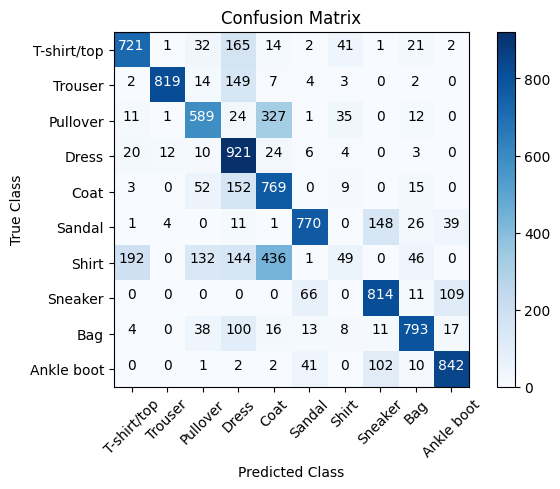

In [30]:
# Confusion Matrix Representation

plt.figure()
plot_confusion_matrix(cnf_matrix_trees, classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], normalize=False, title='Confusion Matrix')


The majority of values are concentrated on the diagonal, so overall, the model performs well. The algorithm correctly predicted 921 images from the "Dress" class. However, images from the "Shirt" class were almost all misclassified, frequently being confused with the "Coat" class (436 misclassifications). Images from the "Pullover" class were also often confused with "Coat." On the other hand, for the other categories, the algorithm achieved reasonable results, with more than 700 correct predictions in most cases.

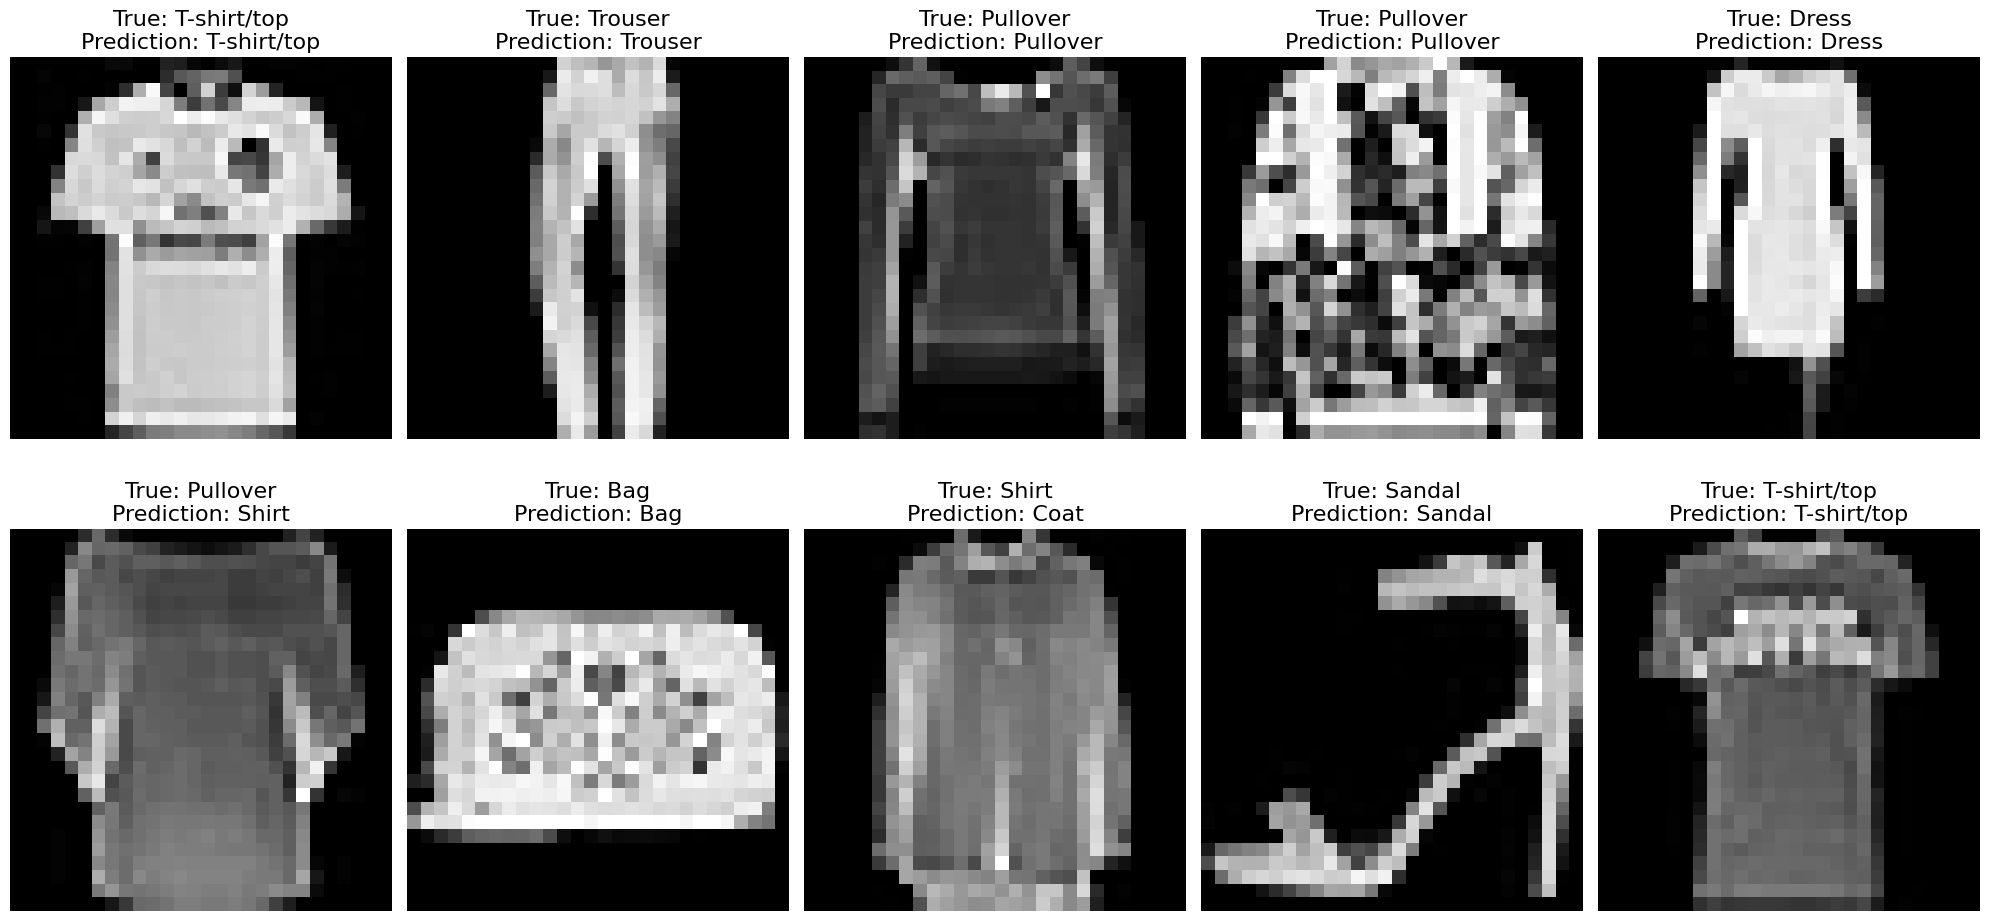

In [31]:
num_images = 10
images = X_test[:num_images]
true_labels = y_test[:num_images]
predicted_labels = clf_entropy.predict(X_test[:num_images])

image_size = int(np.sqrt(images.shape[1]))
reshaped_images = images.reshape(-1, image_size, image_size)

plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(reshaped_images[i], cmap='gray')
    true_label = classes[true_labels[i]]
    predicted_label = classes[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPrediction: {predicted_label}", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

To evaluate the performance of the model in classification, I tested it on a set of 10 images. The algorithm made two errors: it confused a "Pullover" with a "Shirt" and a "Shirt" with a "Coat." Otherwise, it correctly predicted the objects in the images, suggesting a decent ability to distinguish and classify the presented objects.

**Support Vector Machine (SVM)**

Support Vector Machine (SVM) is a supervised learning algorithm used for classification and regression, known for its ability to find an optimal hyperplane that separates different classes of data in a high-dimensional space.

SVM works by maximizing the margin between the closest data points (support vectors) and the hyperplane, ensuring a robust separation of classes. Kernels, such as linear, radial basis function (RBF), polynomial, and sigmoid, allow the algorithm to map data into a higher-dimensional feature space, enabling class separation even when the data is not linearly separable.

Each kernel has specific characteristics and applications, and the correct choice depends on the nature of the data. We will test all these kernel functions to identify which provides the best results in classifying our dataset, comparing the performance of each method.

In [32]:
# Standardizing the data
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

I standardized the data because the algorithm is sensitive to the scale of features. Without standardization, features with larger values can dominate the calculation of distances and margins, affecting the model's performance.

In [33]:
# RBF Kernel (Gaussian Radial Base Function)

# Training the model
svm_rbf = SVC(kernel='rbf', random_state=9)
svm_rbf.fit(X_train_standard, y_train)

# Prediction
y_pred_rbf = svm_rbf.predict(X_test_standard)

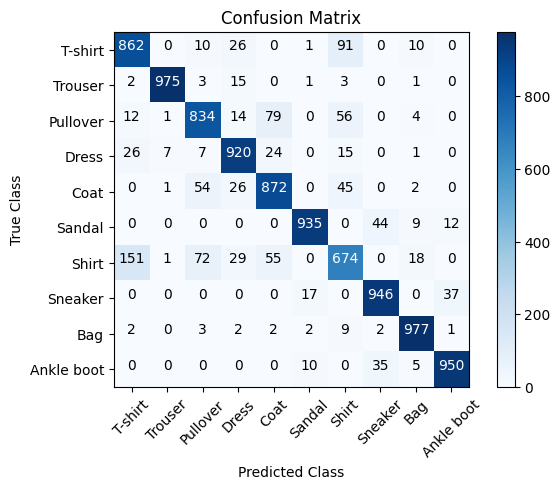

In [34]:
# Confusion Matrix Calculation
cnf_matrix_svm = confusion_matrix(y_test, y_pred_rbf)
np.set_printoptions(precision=2)

# Confusion Matrix Representation

plt.figure()
plot_confusion_matrix(cnf_matrix_svm, classes=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], normalize=False, title='Confusion Matrix')

As observed in the confusion matrix, the class "Bag" is correctly predicted in 977 out of 1000 cases, making it the best classified. On the other hand, the class "Shirt" is the least accurate, with only 674 out of 1000 observations correctly predicted. The algorithm frequently confuses "Shirt" with "T-shirt", with 151 incorrect predictions between these two classes. Overall, the algorithm is able to distinguish and classify most of the objects in the images correctly.

In [35]:
f1_macro = f1_score(y_test, y_pred_rbf, average='macro')
jaccard_macro = jaccard_score(y_test, y_pred_rbf, average='macro')

print("F1 Score: {:.4f}".format(f1_macro))
print("Jaccard Index: {:.4f}".format(jaccard_macro))

F1 Score: 0.8937
Jaccard Index: 0.8163


I calculated the F1 score and Jaccard index to evaluate the classification model's performance, considering the balance between precision and recall, as well as the similarity between the predicted and actual classes.

The F1 score of 0.8937 indicates good model performance, while the Jaccard index of 0.8163 suggests a high similarity between the predicted and actual classes, indicating strong overall performance in object classification.

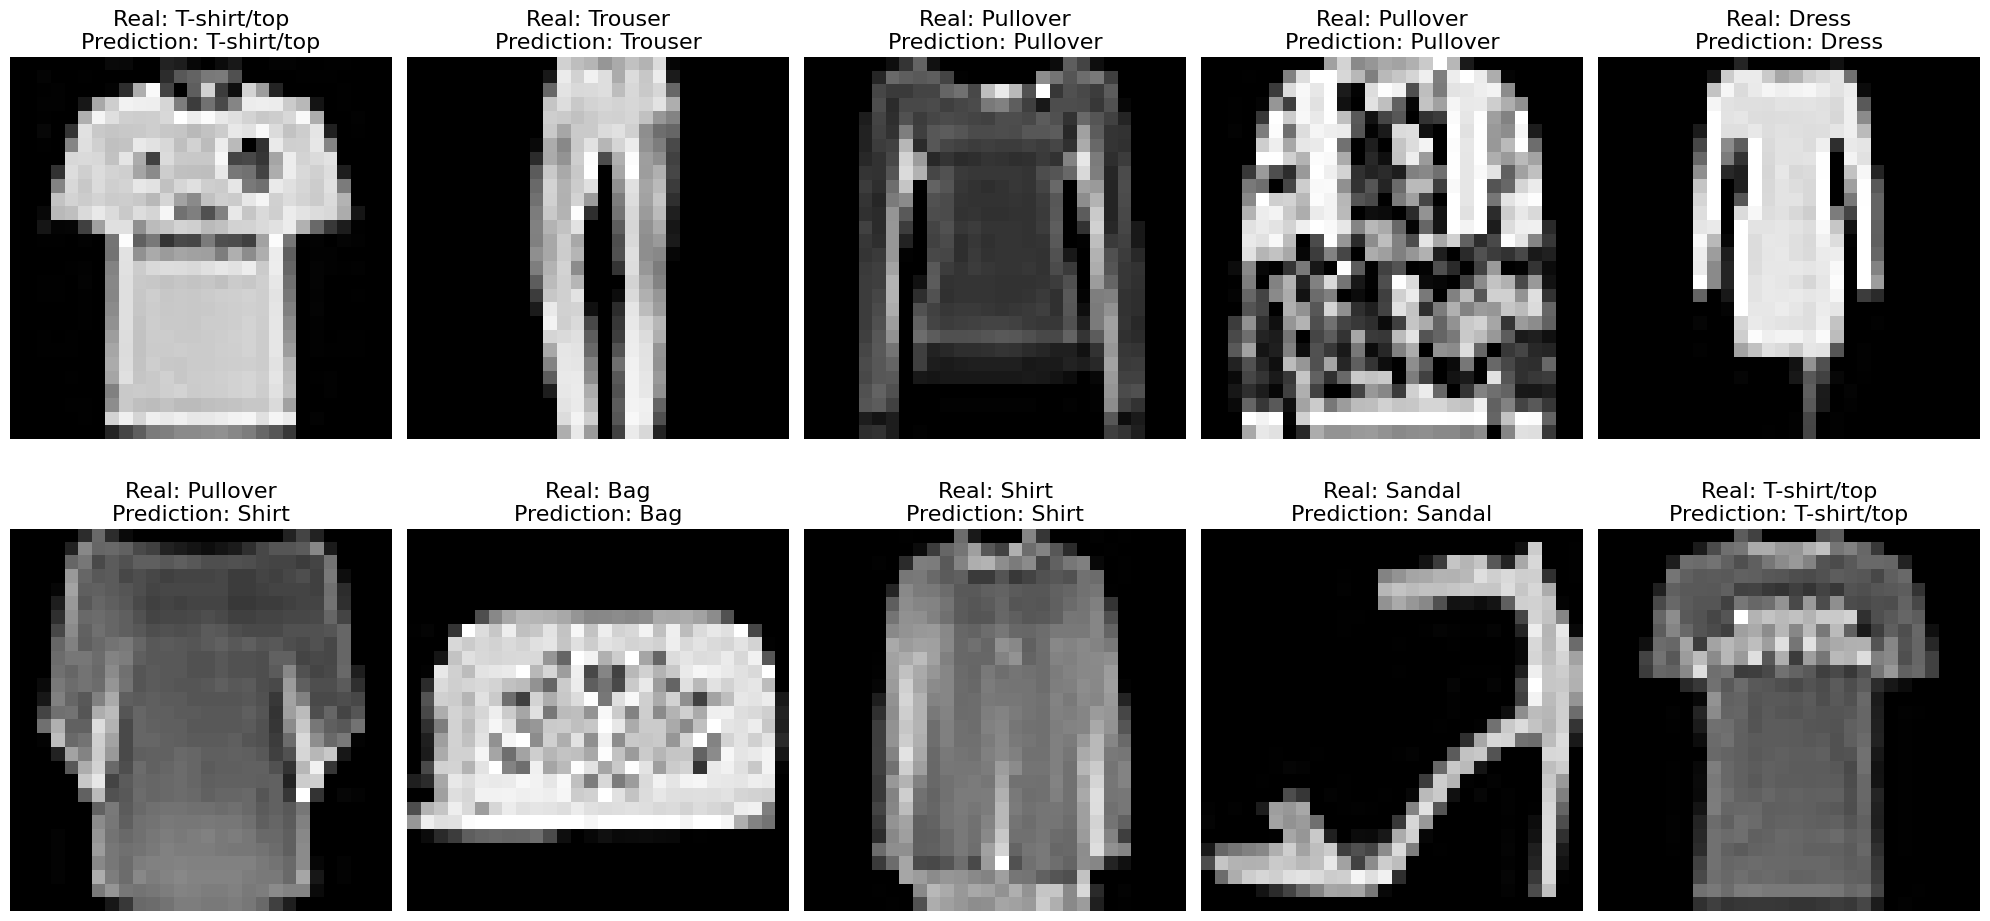

In [36]:
num_images = 10
images = X_test[:num_images]  
true_labels = y_test[:num_images]  
predicted_labels = svm_rbf.predict(X_test_standard[:num_images])  

image_size = int(np.sqrt(images.shape[1]))  
reshaped_images = images.reshape(-1, image_size, image_size)

plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(reshaped_images[i], cmap='gray')  
    true_label = classes[true_labels[i]]  
    predicted_label = classes[predicted_labels[i]]  
    plt.title(f"Real: {true_label}\nPrediction: {predicted_label}", fontsize=16)
    plt.axis('off')  

plt.tight_layout()
plt.show()


In the end, I tested the model on a set of 10 images to observe its classification performance. The SVM algorithm made a single error, confusing a 'Sweater' with a 'Shirt,' but managed to correctly classify all other objects. This suggests that the model has a good ability to distinguish and classify objects in images.

# Neural Networks - CNN (Convolutional Neural Networks)

Neural networks are models used in machine learning, inspired by the structure and functioning of the human brain, that learn to make predictions or classifications based on input data. A special type of neural network, CNN (Convolutional Neural Networks), is part of deep learning and is specifically designed for image classification and processing. It has the ability to automatically extract relevant features from images to analyze them efficiently.

I transformed the image int.mber of images, width, height, and the number of channels (in this case, one channel for grayscale images). This allows the network to correctly process each image during training.

In [37]:
# Reshape for images 
X_train_cnn = X_train_norm.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_norm.reshape(-1, 28, 28, 1)

The CNN model consists of two convolutional layers followed by pooling layers for feature extraction, followed by a flattening layer and two dense layers to perform classification. The output layer uses the softmax activation function to predict the classes.

In [38]:
# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [39]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I compiled the model using the Adam optimizer for weight adjustment, the sparse categorical crossentropy loss function for multi-class classification problems, and accuracy as the metric for evaluating the model's performance.

In [40]:
# Training the model
history = model.fit(X_train_cnn, y_train, epochs=15, validation_split=0.2)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6827 - loss: 0.8603 - val_accuracy: 0.8583 - val_loss: 0.3963
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8306 - loss: 0.4710 - val_accuracy: 0.8788 - val_loss: 0.3359
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8522 - loss: 0.4052 - val_accuracy: 0.8933 - val_loss: 0.3046
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.8669 - loss: 0.3629 - val_accuracy: 0.8925 - val_loss: 0.2999
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.8737 - loss: 0.3447 - val_accuracy: 0.8908 - val_loss: 0.2968
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.8779 - loss: 0.3286 - val_accuracy: 0.9007 - val_loss: 0.2758
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8828 - loss: 0.3151 - val_accuracy: 0.9032 - val_loss: 0.2678
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.8884 -

I trained the model for 15 epochs using the training set, with 20% of the data reserved for validation/testing to evaluate the model's performance on new data during the training process.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9154 - loss: 0.2303
Test accuracy: 0.9181


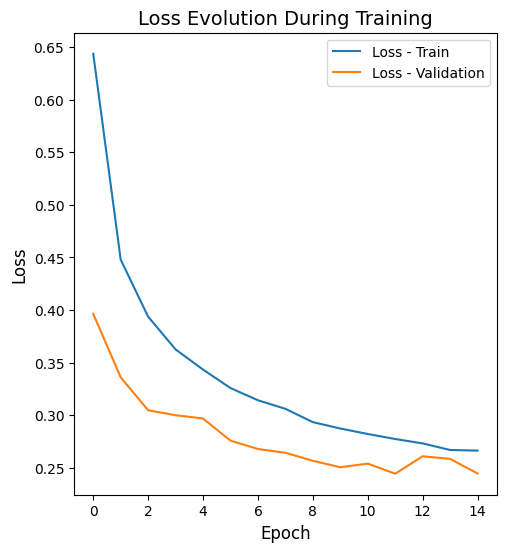

In [41]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Visualizing the model's performance (training curves)
plt.figure(figsize=(12, 6))

# Loss evolution
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss - Train')
plt.plot(history.history['val_loss'], label='Loss - Validation')
plt.title('Loss Evolution During Training', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()


The model's accuracy on the test set is 0.9158, indicating very good performance, with 91.46% of predictions being correct.

The graph shows the evolution of the loss during training, where the loss for the training set (loss - train) and for the validation set (val_loss) decreases as the number of iterations increases. This suggests that the model is improving its ability to generalize to new data as it trains.

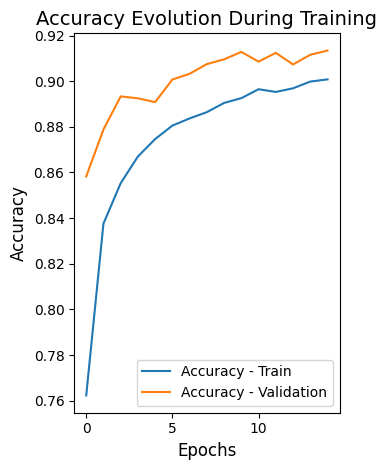

In [42]:
# Accuracy evolution
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy - Train')
plt.plot(history.history['val_accuracy'], label='Accuracy - Validation')
plt.title('Accuracy Evolution During Training', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

The graph shows that both the training and validation accuracy steadily increase as the number of epochs (iterations) increases, indicating that the model is learning and generalizing better on both datasets throughout the training process.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


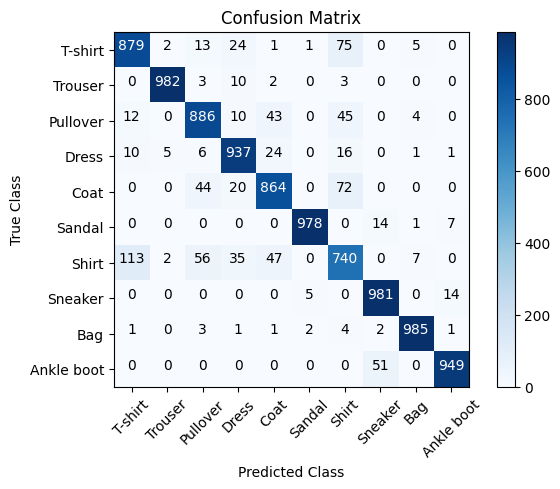

In [43]:
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Calculating the confusion matrix
cnf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plotting the confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn, classes=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], normalize=False, title='Confusion Matrix')


From the confusion matrix, we can observe that the classes "Bag" and "Trouser" have the best results (988 and 985 correct classifications, respectively). Once again, the class "Shirt" is the most poorly predicted (698), often being confused with the class "T-shirt." Overall, the algorithm classifies the objects in the images very well.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


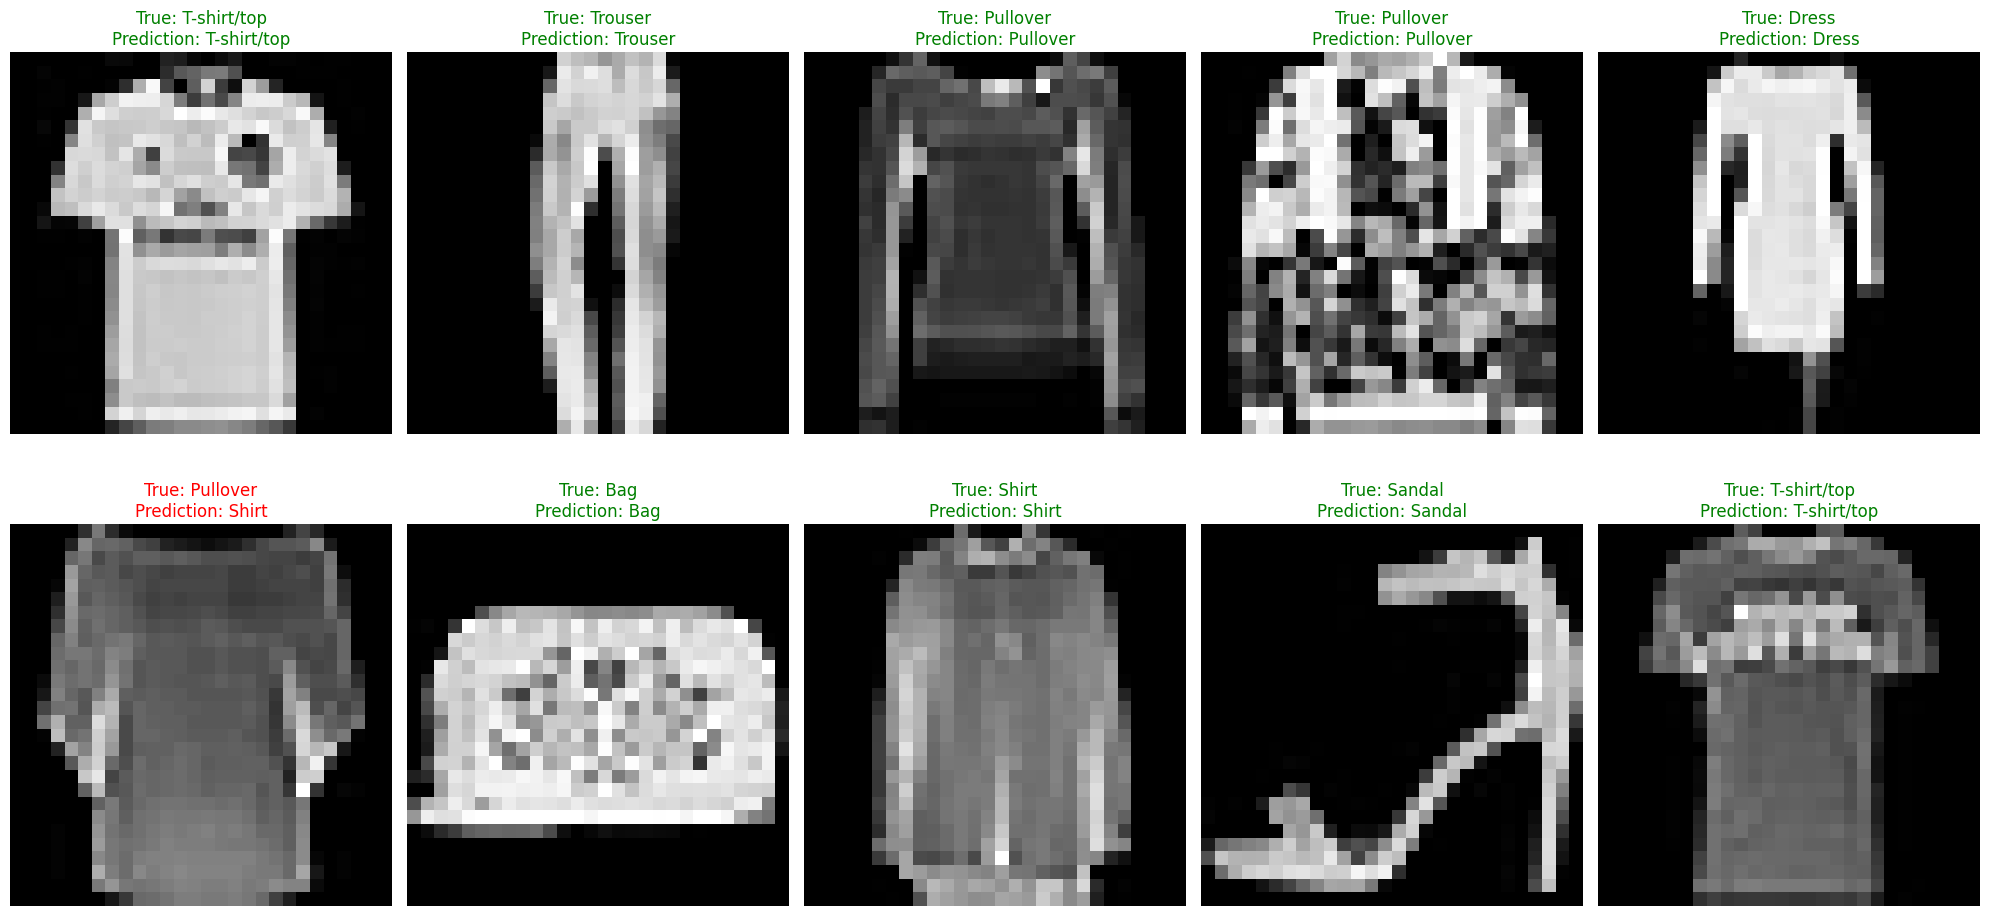

In [44]:
# Visualizing predictions
num_images = 10
images = X_test_cnn[:num_images]  
true_labels = y_test[:num_images] 

# Getting CNN model predictions
predicted_probs = model.predict(images) 
predicted_labels = np.argmax(predicted_probs, axis=1)  

# Preparing images for display
reshaped_images = images.squeeze()  

# Creating the plot
plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(reshaped_images[i], cmap='gray')  
    true_label = classes[true_labels[i]] 
    predicted_label = classes[predicted_labels[i]] 
    plt.title(f"True: {true_label}\nPrediction: {predicted_label}", fontsize=12, color='green' if true_label == predicted_label else 'red')
    plt.axis('off')  

plt.tight_layout()
plt.show()


From the test conducted on 10 images, we observe only one mistake: a "Sweater" was classified as a "Shirt."

# Comparisons

After applying machine learning and deep learning algorithms, we compare the results based on prediction accuracy and the errors of each model to evaluate the performance of each approach and identify the most accurate model for the given dataset.

           Model  Accuracy  Precision  Recall  F1 Score
0            KNN    0.8607   0.863358  0.8607  0.859615
1  Decision Tree    0.7087   0.706296  0.7087  0.687761
2            SVM    0.8945   0.893688  0.8945  0.893688
3            CNN    0.9181   0.917791  0.9181  0.917781


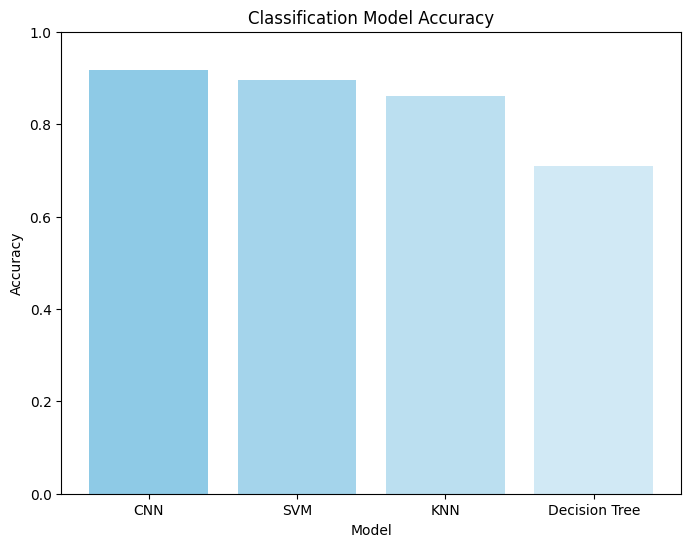

In [45]:
# Results
results = {
    "Model": ["KNN", "Decision Tree", "SVM", "CNN"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_entropy),
        accuracy_score(y_test, y_pred_rbf),
        accuracy_score(y_test, y_pred_cnn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_knn, average='weighted'),
        precision_score(y_test, y_pred_entropy, average='weighted'),
        precision_score(y_test, y_pred_rbf, average='weighted'),
        precision_score(y_test, y_pred_cnn, average='weighted')
    ],
    "Recall": [
        recall_score(y_test, y_pred_knn, average='weighted'),
        recall_score(y_test, y_pred_entropy, average='weighted'),
        recall_score(y_test, y_pred_rbf, average='weighted'),
        recall_score(y_test, y_pred_cnn, average='weighted')  
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_knn, average='weighted'),
        f1_score(y_test, y_pred_entropy, average='weighted'),
        f1_score(y_test, y_pred_rbf, average='weighted'),
        f1_score(y_test, y_pred_cnn, average='weighted')
    ]
}

# Results table
results_df = pd.DataFrame(results)
print(results_df)

# Sort by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Graph
opacity_values = np.linspace(1, 0.4, len(results_df))
plt.figure(figsize=(8, 6))
for i in range(len(results_df)):
    plt.bar(results_df["Model"].iloc[i], results_df["Accuracy"].iloc[i],
            color="#8ecae6", alpha=opacity_values[i]) 
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Classification Model Accuracy")
plt.ylim([0, 1]) 
plt.show()


           Model     MAE     MSE      RMSE
0            KNN  0.4630  1.9626  1.400928
1  Decision Tree  0.8190  2.9636  1.721511
2            SVM  0.3540  1.5266  1.235557
3            CNN  0.2724  1.1642  1.078981


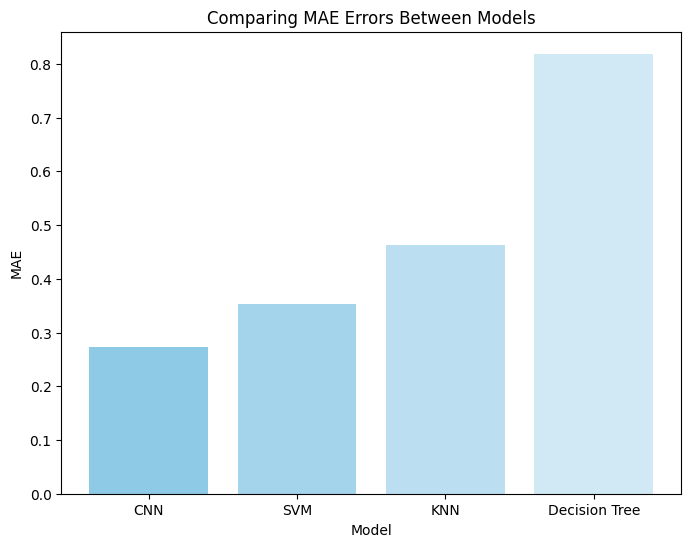

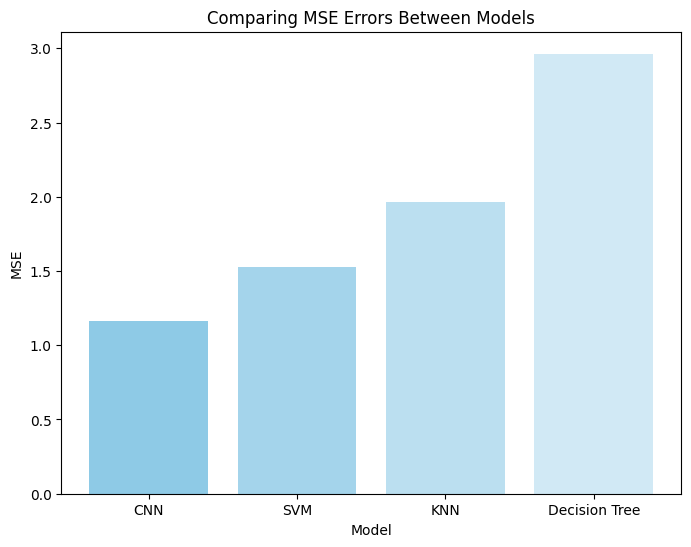

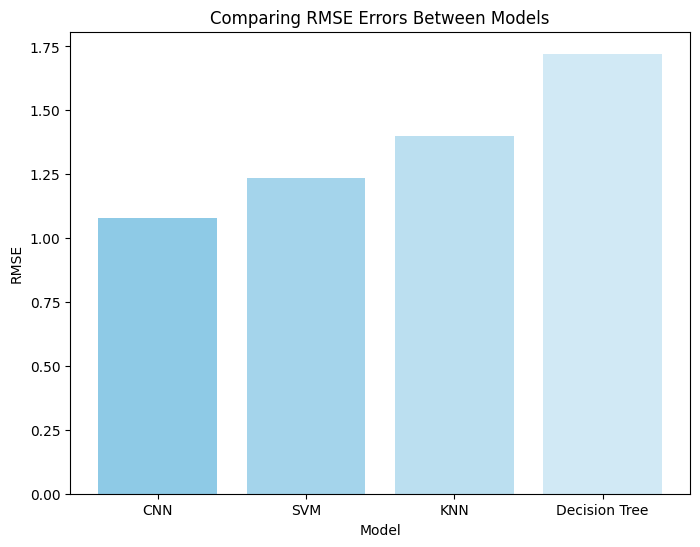

In [46]:
# Error Calculation
error_results = {
    "Model": ["KNN", "Decision Tree", "SVM", "CNN"]
}

error_results["MAE"] = [
    mean_absolute_error(y_test, y_pred_knn),
    mean_absolute_error(y_test, y_pred_entropy),
    mean_absolute_error(y_test, y_pred_rbf),
    mean_absolute_error(y_test, y_pred_cnn)
]

error_results["MSE"] = [
    mean_squared_error(y_test, y_pred_knn),
    mean_squared_error(y_test, y_pred_entropy),
    mean_squared_error(y_test, y_pred_rbf),
    mean_squared_error(y_test, y_pred_cnn)
]

error_results["RMSE"] = [
    np.sqrt(mean_squared_error(y_test, y_pred_knn)),
    np.sqrt(mean_squared_error(y_test, y_pred_entropy)),
    np.sqrt(mean_squared_error(y_test, y_pred_rbf)),
    np.sqrt(mean_squared_error(y_test, y_pred_cnn))
]

error_results_df = pd.DataFrame(error_results)
print(error_results_df)

# Sorting the results for each metric
error_results_df_sorted_mae = error_results_df.sort_values(by="MAE", ascending=True)
error_results_df_sorted_mse = error_results_df.sort_values(by="MSE", ascending=True)
error_results_df_sorted_rmse = error_results_df.sort_values(by="RMSE", ascending=True)

# MAE Graph
plt.figure(figsize=(8, 6))
opacity_values_mae = np.linspace(1, 0.4, len(error_results_df_sorted_mae))
for i in range(len(error_results_df_sorted_mae)):
    plt.bar(error_results_df_sorted_mae["Model"].iloc[i], error_results_df_sorted_mae["MAE"].iloc[i],
            color="#8ecae6", alpha=opacity_values_mae[i])
plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("Comparing MAE Errors Between Models")
plt.show()

# MSE Graph
plt.figure(figsize=(8, 6))
opacity_values_mse = np.linspace(1, 0.4, len(error_results_df_sorted_mse))
for i in range(len(error_results_df_sorted_mse)):
    plt.bar(error_results_df_sorted_mse["Model"].iloc[i], error_results_df_sorted_mse["MSE"].iloc[i],
            color="#8ecae6", alpha=opacity_values_mse[i])
plt.xlabel("Model")
plt.ylabel("MSE")
plt.title("Comparing MSE Errors Between Models")
plt.show()

# RMSE Graph
plt.figure(figsize=(8, 6))
opacity_values_rmse = np.linspace(1, 0.4, len(error_results_df_sorted_rmse))
for i in range(len(error_results_df_sorted_rmse)):
    plt.bar(error_results_df_sorted_rmse["Model"].iloc[i], error_results_df_sorted_rmse["RMSE"].iloc[i],
            color="#8ecae6", alpha=opacity_values_rmse[i])
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Comparing RMSE Errors Between Models")
plt.show()


# Conclusion

Based on the results obtained, the CNN model has the best performance, with an accuracy of 91.58% and the lowest errors (MAE = 0.2863, RMSE = 1.1163), making it the most efficient for classifying images in the Fashion MNIST dataset.

The SVM model ranks second, with an accuracy of 89.45% and significantly lower errors compared to KNN and Decision Tree.

In contrast, the Decision Tree model has the weakest performance, with a low accuracy (70.87%) and the highest errors, indicating that it is not well-suited for this type of problem.

These results were expected, given that CNNs are specifically designed for image classification, leveraging spatial relationships and visual features, while SVM is known to be one of the most effective machine learning algorithms for complex classifications, which explains its high performance in this context.